# Continous Controller Design

### PID with Low Pass Filter on Derivative Term

A PID controller with a low pass filter on the derivative has the following form.

\begin{align}
    G_c(s) &= k_p + k_i\frac{1}{s} + k_d \frac{s}{s/\omega_p + 1} \\
    &= \frac{(k_p/\omega_p + k_d)s^2 + (k_p + k_i/\omega_p)s + k_i}{s(s/\omega_p + 1)} \\
    &=k_{dc} \frac{(s/\omega_{z1} + 1)(s/\omega_{z2} + 1)}{s(s/\omega_p + 1)}
\end{align}

where,

\begin{align}
    k_p &= k_{dc} \bigg(\frac{\omega_{z1} + \omega_{z2}}{\omega_{z1}\omega_{z2}} - \frac{1}{\omega_p}\bigg) \\
    k_i &= k_{dc} \\
    k_d &= k_{dc} \bigg(\frac{1}{\omega_{z1} \omega_{z2}} - \frac{\omega_{z1} + \omega_{z2}}{\omega_{z1}\omega_{z2} \omega_p} + \frac{1}{\omega_p^2}\bigg) 
\end{align}

We see that the controller can be written out as a DC gain with two zeros, a pole, and a pole at the origin which represents 4 design variables that we can manipulate. We will define the bandwidth of our position controller and current regulator to be $\omega_c$ and $\omega_{ci}$ respectively.

We can systematically place these poles and zeros to achieve the phase margin and bandwidth that we desire. Note that this is two input variables but we have four parameters to determine so some engineering judgement must be taken into account. The arbitrary choices that we will be as follows:

\begin{align}
    \omega_{z1} &= \frac{\omega_c}{100} \\
    \omega_p &= 4\omega_c
\end{align}

$\omega_{z1}$ is placed two decades below our controller bandwidth because the kernel of our loop gain starts out at -180 degrees and we need to gain phase. Zero's increase the phase of the system.

$\omega_p$ is placed 4 times higher than the bandwidth of our controller such that it can filter out noise but doesn't affect the overall system dynamics.

The second zero location is chosen to give the desired phase margin as:

\begin{align}
    \omega_{z2} = \frac{\omega_c}{\tan{\big(\phi_{\textrm{PM}} + \pi/2 + \arctan{\frac{\omega_{c}}{\omega_{ci}}} - \arctan{\frac{\omega_{c}}{\omega_{ci}}} + \arctan{\frac{\omega_{z1}}{\omega_{p}}} \big)}}
\end{align}

Finally, the DC gain is set such that the gain cross-over frequency occurs at the desired controller bandwidth:

\begin{align}
    k_{dc} = \frac{1}{\bigg|G_c(j\omega_c)\big|_{k_{dc} = 1}\bigg||I_{CL}(j\omega_c)|G_p(j\omega_c)|}
\end{align}


# Continuous to Discrete Time Controller Implementation

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
s, z_inv, T, kp, ki, kd, wp, M, E, tau = sp.symbols('s z^-1 T k_p k_i k_d \omega_p M(z) E(z) tau')

We can use the tustin transformation (trapezoidal integration) to transform our continous time controller into an approximately equivalent discrete time controller:

By definition:

\begin{align}
z = e^{sT} = \frac{e^{sT/2}}{e^{-sT/2}}
\end{align}

Using the first order terms of a Taylor series expansion for the exponential we get:

\begin{align}
z \approx \frac{1 + sT/2}{1 - sT/2}
\end{align}

solving for s we get:

\begin{align}
s \approx \frac{2}{T}\frac{z-1}{z+1} = \frac{2}{T}\frac{1-z^{-1}}{1+z^{-1}}
\end{align}

We will use this above expression to develop difference equations that we can implement in code for each term of our controller:

In [3]:
s_expr = (2/T)*(1-z_inv)/(1 + z_inv)
s_expr

2*(1 - z^-1)/(T*(z^-1 + 1))

### Proportional Control:

The proportional controller is simple. The manipulation is as follows:

\begin{align}
m_{n,P} = k_p e_n
\end{align}

### Integral Control

Using the Tustin transform on the integral term:

In [4]:
I = ki/s
Ieq = sp.Eq(M/E, I.subs({s:s_expr}))
Ieq

Eq(M(z)/E(z), T*k_i*(z^-1 + 1)/(2*(1 - z^-1)))

We get the following difference equation:

\begin{align}
m_{n,I} = m_{n-1,I} + k_i \frac{T}{2} (e_n + e_{n-1})
\end{align}

### Derivative Control with Low-Pass Filter

In [5]:
D = kd*(s/(s/wp + 1))
D

k_d*s/(1 + s/\omega_p)

In [6]:
Deq = sp.Eq(M/E, D.subs(s,s_expr))
Deq.expand().simplify().factor(z_inv)

Eq(M(z)/E(z), -2*\omega_p*k_d*(z^-1 - 1)/(T*\omega_p + z^-1*(T*\omega_p - 2) + 2))

We get the following difference equation:

\begin{align}
m_n (T\omega_p + 2) - m_{n-1} (2-T\omega_p) = 2\omega_p k_d (e_n - e_{n-1})
\end{align}

\begin{align}
m_n = \frac{2-T\omega_p}{T\omega_p + 2} m_{n-1} + \frac{2\omega_p k_d}{T\omega_p + 2} (e_n - e_{n-1})
\end{align}

which can be rewritten as:

\begin{align}
m_{n,D} = k_{md} m_{n-1,D} + k_{ed} (e_n - e_{n-q})
\end{align}

where:

\begin{align}
k_{md} = \frac{2-T\omega_p}{T\omega_p + 2}
\end{align}

\begin{align}
k_{ed} = \frac{2\omega_p k_d}{T\omega_p + 2}
\end{align}

### Total Controller:

The total controller manipulation will be the sum of each of the PID terms as:

\begin{align}
m_n = m_{n,P} + m_{n,I} + m_{n,D}
\end{align}

\begin{align}
m_{n,P} = k_p e_n
\end{align}

\begin{align}
m_{n,I} = m_{n-1,I} + k_i \frac{T}{2} (e_n + e_{n-1}) = m_{n-1,I} + k_{ei} (e_n + e_{n-1})
\end{align}

\begin{align}
m_{n,D} = k_{md} m_{n-1,D} + k_{ed} (e_n - e_{n-1})
\end{align}

At this point, we could write out one long expression for the controller output in terms of the previous the current error, previous error and previous manipulations. We will make the concious decision not to do this however as we would like to keep the integral term seperate in order to be able to apply an anti-windup scheme to it.

### Anti-Windup

We will use clamping for an anti-windup scheme as it is easy to implement and does not have any parameters that require tuning. Clamping works by stopping (or clamping) the integration on the integral control as soon as the following two criteria are met:

1) The controller output is saturating: `|m_n| > maximum allowable manipulation`

2) The integral control is trying to make things worse: `sign(e_n) == sign(m_n)`

If we define the following boolean variable:

`clamp = saturating && integral_makes_worse`

then we can modify our integral control expression to the following:

\begin{align}
m_{n,I} = m_{n-1,I} + k_{ei} (e_n + e_{n-1})(1 - \textrm{clamp})
\end{align}

### Low Pass Filter on Input Commands

To smooth the initial transients of the start up and create a trajectory that can actually be followed, we can pass our commands through a low pass filter. To do this, we can measure the initial position of the rotor and then command that position until a certain time at which we use a step command to the desired centered position. The step command will be smoothed into an exponential curve when passed through the filter:

A simple low pass filter can be designed as a single pole (first order system):

\begin{align}
G(s) = \frac{1}{\tau s + 1}
\end{align}

The transfer function has a gain of unity and will respond to a step input as an exponential with time constant of $\tau$

In [7]:
lowpass = 1/(tau*s + 1)
lowpass

1/(s*tau + 1)

In [8]:
lowpass.subs({s:s_expr}).expand().simplify().factor(z_inv)

T*(z^-1 + 1)/(T + 2*tau + z^-1*(T - 2*tau))

We get the following difference equation:

\begin{align}
y_{n} (T + 2\tau) - y_{n-1} (2\tau - T) = T(x_{n} + x_{x-1})
\end{align}

\begin{align}
y_{n} = \frac{2\tau - T}{T + 2\tau} y_{n-1}  + \frac{T}{T + 2\tau}(x_{n} + x_{n-1}) = k_{yLP} y_{n-1} + k_{xLP} ( x_{n} + x_{n-1} )
\end{align}

Let's take a look at the discrete step response to the filter we've created

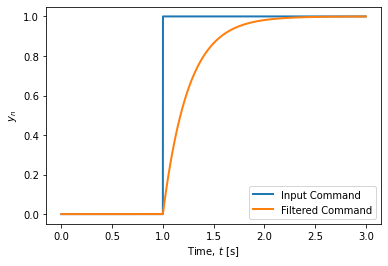

In [9]:
Ts = 1/10_000
tau_n = 0.25

T_settle = 8*tau_n
T_on = 1

total_samples = int((T_on + T_settle)/Ts)
samples_off = int(T_on/Ts)

t_arr = np.linspace(0, total_samples*Ts, total_samples)

kmlp = (2*tau_n - Ts)/(Ts + 2*tau_n)
kelp = Ts/(Ts + 2*tau_n)

x = np.ones(total_samples)
x[0:samples_off] = 0
y = np.zeros_like(x)

for i, val in enumerate(x):
        
        if i == 0:
            pass
        else:
            y[i] = y[i-1]*kmlp + kelp*(x[i] + x[i-1])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_arr, x, lw = 2, label = 'Input Command')
ax.plot(t_arr, y, label = 'Filtered Command', lw = 2)
ax.set_xlabel('Time, $t$ [s]')
ax.set_ylabel('$y_n$')
ax.legend();